In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.12.0


In [5]:
# Set parameters here 
INPUT_SIZE = 256
BATCH_SIZE = 64

SEED = 12345
np.random.seed(SEED)

path = '../data/caltech-101/101_ObjectCategories'
classes = os.listdir(path)
myclasses = classes
myclasses.remove('BACKGROUND_Google')
myclasses.remove('Faces')
myclasses.remove('.DS_Store')

NUMCLASSES = len(myclasses)

mapping = {}
for i in range(NUMCLASSES):
    mapping[i] = myclasses[i]


In [6]:
from skimage import exposure
from tensorflow.keras.applications import vgg16


def preprocess(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale


In [7]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=True,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=True,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=1./255,
                                preprocessing_function=vgg16.preprocess_input,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [8]:
# Make a dataframe with all the file paths and labels
allfilelist = []
alllabels = []
alllabels_word = []
for i in range(NUMCLASSES):
    filepath = path + '/' + myclasses[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(myclasses[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()
    


,filename,labelnum,label
8237,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8238,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8239,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8240,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8241,../data/caltech-101/101_ObjectCategories/metro...,99,metronome


In [9]:
# This next line is to use only some x% of the data
df = df.sample(frac=1.0)
df.head()

,filename,labelnum,label
7711,../data/caltech-101/101_ObjectCategories/Faces...,94,Faces_easy
1572,../data/caltech-101/101_ObjectCategories/airpl...,18,airplanes
1531,../data/caltech-101/101_ObjectCategories/airpl...,18,airplanes
8044,../data/caltech-101/101_ObjectCategories/llama...,96,llama
7602,../data/caltech-101/101_ObjectCategories/Faces...,94,Faces_easy


In [10]:
print(df['label'].value_counts())

label
airplanes       800
Motorbikes      798
Faces_easy      435
watch           239
Leopards        200
               ... 
garfield         34
platypus         34
binocular        33
metronome        32
inline_skate     31
Name: count, Length: 100, dtype: int64


In [11]:


training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 6594 validated image filenames belonging to 100 classes.
Found 1648 validated image filenames belonging to 100 classes.


In [12]:
# from tensorflow.keras.applications import VGG16


#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58889256/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x1692675d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17ae73710> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x179e82710> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17ae73c90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17b01c910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17ae72c90> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17b03a990> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x174d979d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17b038790> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x179e7f850> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x164089c10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x179964a10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17b068490> Fa

In [13]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUMCLASSES, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               102500    
                                                                 
Total params: 48,372,644
Trainable params: 40,737,380
Non-trainable params: 7,635,264
_________________________________________________________________


In [15]:
#Training

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
num_epochs = 10
history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=num_epochs, validation_data=validation_set,
                   validation_steps = len(validation_set))

model.save_weights("model-normalized-aug-vgg.h5")
print("Saved model to disk after",num_epochs,"epochs.")
# model.load_weights('model-normalized-aug.h5')

Epoch 1/10


2025-03-26 11:25:35.886637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-26 11:25:35.889277: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


104/104 [==============================] - ETA: 0s - loss: 5.3969 - acc: 0.1359    

2025-03-26 11:38:50.637262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 988s 10s/step - loss: 5.3969 - acc: 0.1359 - val_loss: 4.8703 - val_acc: 0.2154
Epoch 2/10
104/104 [==============================] - 1092s 11s/step - loss: 3.1533 - acc: 0.3447 - val_loss: 2.5642 - val_acc: 0.4266
Epoch 3/10
104/104 [==============================] - 1083s 10s/step - loss: 2.3075 - acc: 0.4857 - val_loss: 2.1081 - val_acc: 0.5085
Epoch 4/10
104/104 [==============================] - 1129s 11s/step - loss: 1.7048 - acc: 0.6146 - val_loss: 1.4809 - val_acc: 0.6481
Epoch 5/10
104/104 [==============================] - 1148s 11s/step - loss: 1.2934 - acc: 0.6979 - val_loss: 1.4346 - val_acc: 0.6547
Epoch 6/10
104/104 [==============================] - 1074s 10s/step - loss: 0.9273 - acc: 0.7712 - val_loss: 1.2477 - val_acc: 0.7263
Epoch 7/10
104/104 [==============================] - 1041s 10s/step - loss: 0.8298 - acc: 0.8136 - val_loss: 1.1839 - val_acc: 0.7415
Epoch 8/10
104/104 [==============================] - 1111s 11s/ste

In [16]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

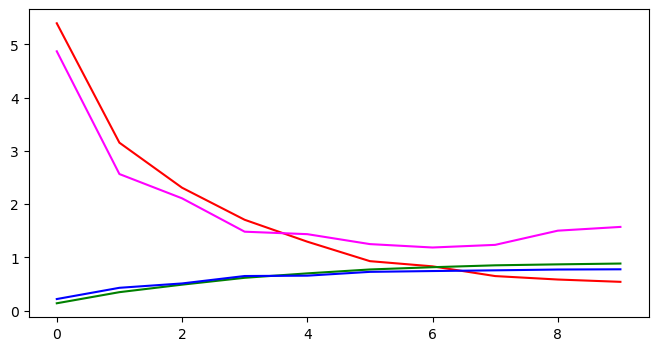

In [17]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['acc'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_acc'],color='blue')
plt.show()

1/1 [==============================] - 0s 111ms/step
Real class: pizza
Predictions:
anchor : 0.25731722
dolphin : 0.2156284
minaret : 0.14086837
brain : 0.05861966
hedgehog : 0.05794059


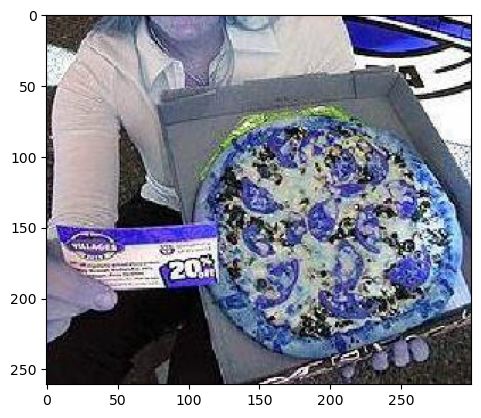

In [30]:
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = path + '/' + myclasses[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))
while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))
image_path = folder + '/' + filelist[i]
image = cv2.imread(image_path)
plt.imshow(image)

# Prepare image
img = tf.keras.preprocessing.image.load_img(image_path)
img = tf.keras.preprocessing.image.img_to_array(img)
#img = preprocess(img)
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

# Print what the top predicted class is
#print(img_tensor.shape)
preds = model.predict(img_tensor,steps=1)
preds = preds.flatten()
#print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', myclasses[classnum])
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])


2025-03-31 12:15:06.527606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 147s 6s/step
Real class: Faces_easy	Prediction: Leopards
Real class: airplanes	Prediction: headphone
Real class: airplanes	Prediction: helicopter
Real class: llama	Prediction: gramophone
Real class: Faces_easy	Prediction: sea_horse
Real class: Motorbikes	Prediction: Motorbikes
Real class: accordion	Prediction: ketch
Real class: flamingo	Prediction: dolphin
Real class: airplanes	Prediction: Motorbikes
Real class: Leopards	Prediction: lotus
Real class: airplanes	Prediction: elephant
Real class: Faces_easy	Prediction: hawksbill
Real class: scissors	Prediction: umbrella
Real class: airplanes	Prediction: anchor
Real class: brain	Prediction: scorpion
Real class: ketch	Prediction: airplanes
Real class: Motorbikes	Prediction: stop_sign
Real class: buddha	Prediction: ketch
Real class: gerenuk	Prediction: hawksbill
Real class: ewer	Prediction: joshua_tree
Real class: strawberry	Prediction: Faces_easy
Real class: buddha	Prediction: cellphone
Real class: lo

array([ 90.,  35., 150.,   9., 159.,   6.,   9.,  14.,  12.,   8.,  10.,
        29.,  17.,   6.,  14.,  15.,   7.,   9.,  23.,  10.,   9.,  13.,
        13.,  10.,  11.,  11.,  10.,  15.,  16.,  16.,  18.,   7.,  12.,
        17.,   9.,  17.,   9.,  10.,  17.,  15.,  13.,   6.,   5.,   7.,
        11.,  14.,  22.,  12.,   8.,  16.,  21.,   7.,  14.,  16.,  24.,
        12.,  18.,  12.,   9.,  15.,  16.,   5.,  12.,   5.,  22.,   7.,
         8.,  11.,   8.,   6.,  13.,   6.,   8.,  14.,  16.,  11.,   7.,
         8.,  16.,  11.,  21.,  13.,   7.,  15.,   7.,  15.,  10.,  13.,
         7.,  15.,  12.,  19.,  22.,  51.,   9.,  19.,   7.,  12.,   5.,
        10.])

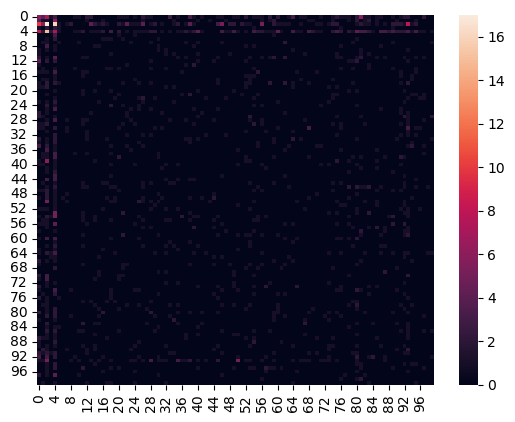

In [26]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions,1)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts    

In [ ]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)